In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
%matplotlib inline
sns.set(style="whitegrid")


### 1. Carregamento e Exploração Inicial dos Dados
##### Carregamos o dataset e realizamos uma análise exploratória inicial para entender a estrutura dos dados, identificar possíveis valores ausentes e obter estatísticas descritivas.

In [34]:
df = pd.read_csv('smart_home_energy_usage_dataset.csv')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   timestamp               1000000 non-null  object 
 1   home_id                 1000000 non-null  int64  
 2   energy_consumption_kWh  1000000 non-null  float64
 3   temperature_setting_C   1000000 non-null  float64
 4   occupancy_status        1000000 non-null  object 
 5   appliance               1000000 non-null  object 
 6   usage_duration_minutes  1000000 non-null  int64  
 7   season                  1000000 non-null  object 
 8   day_of_week             1000000 non-null  object 
 9   holiday                 1000000 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 76.3+ MB


In [36]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

### 2. Análise das Variáveis Categóricas
##### Examinamos a distribuição das categorias nas colunas categóricas para entender a composição dos dados.

In [37]:
columns = ['season', 'day_of_week', 'occupancy_status', 'appliance', 'holiday', ]

for colum in columns:
    print(f"\n\nColuna: {colum}")
    print(df[colum].value_counts())
    print(df[colum].unique())
    print(df[colum].isnull().sum())
    print(df[colum].dtypes)
    print(df[colum].describe())
    
    



Coluna: season
season
Autumn    250372
Summer    250046
Winter    250023
Spring    249559
Name: count, dtype: int64
['Spring' 'Summer' 'Autumn' 'Winter']
0
object
count     1000000
unique          4
top        Autumn
freq       250372
Name: season, dtype: object


Coluna: day_of_week
day_of_week
Sunday       142872
Monday       142872
Tuesday      142864
Wednesday    142848
Thursday     142848
Friday       142848
Saturday     142848
Name: count, dtype: int64
['Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday']
0
object
count     1000000
unique          7
top        Sunday
freq       142872
Name: day_of_week, dtype: object


Coluna: occupancy_status
occupancy_status
Occupied      500394
Unoccupied    499606
Name: count, dtype: int64
['Occupied' 'Unoccupied']
0
object
count      1000000
unique           2
top       Occupied
freq        500394
Name: occupancy_status, dtype: object


Coluna: appliance
appliance
Lighting           167310
Refrigerator       166804
Elect

### 3. Limpeza dos Dados
##### Removemos registros com consumo de energia negativo e convertendo a coluna occupancy_status para binário.

In [ ]:
df = df[df['energy_consumption_kWh'] >= 0].reset_index(drop=True)
print(f"\nNúmero de registros após remoção de inconsistências: {df.shape[0]}")


Número de registros após remoção de inconsistências: 1000000


In [ ]:
df['occupied'] = df['occupancy_status'].apply(lambda x: 1 if x == 'Occupied' else 0)


### 4. Engenharia de Features Temporais
##### Extraímos informações temporais da coluna timestamp para criar novas features que possam influenciar o consumo de energia.

In [ ]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['day_of_week_num'] = df['timestamp'].dt.dayofweek  
df['hour'] = df['timestamp'].dt.hour


df['peak_hour'] = df['hour'].apply(lambda x: 1 if 18 <= x <= 21 else 0)


### 5. Agregação Diária por home_id
##### Agregamos os dados diariamente por home_id para obter uma visão mais consolidada do consumo de energia.

In [ ]:
df_daily = df.set_index('timestamp').groupby(['home_id', pd.Grouper(freq='D')]).agg({
    'energy_consumption_kWh': 'sum',
    'temperature_setting_C': 'mean',
    'occupied': 'max',  
    'peak_hour': 'sum',  
    'season': 'first',
    'day_of_week_num': 'first',
    'holiday': 'first',
    'appliance': 'first',
    'day_of_week': 'first'

}).reset_index()

print("\nDados agregados diariamente por home_id:")
print(df_daily.head())



Dados agregados diariamente por home_id:
   home_id  timestamp  energy_consumption_kWh  temperature_setting_C  \
0        1 2023-01-04                    4.48                   18.0   
1        1 2023-01-08                    1.40                   24.1   
2        1 2023-01-10                    2.68                   18.2   
3        1 2023-01-12                    3.93                   24.0   
4        1 2023-01-16                    3.25                   16.4   

   occupied  peak_hour  season  day_of_week_num  holiday        appliance  \
0         1          0  Winter                2        0         Lighting   
1         0          1  Spring                6        0     Refrigerator   
2         0          0  Summer                1        0     Refrigerator   
3         1          0  Winter                3        0         Lighting   
4         0          0  Winter                0        0  Washing Machine   

  day_of_week  
0   Wednesday  
1      Sunday  
2     Tuesday 

### 6. Codificação de Variáveis Categóricas
##### Convertendo variáveis categóricas em numéricas utilizando One-Hot Encoding para que possam ser utilizadas pelos modelos de Machine Learning.

In [ ]:
categorical_features = ['season', 'appliance', 'day_of_week']


df_daily = pd.get_dummies(df_daily, columns=categorical_features, drop_first=True)

print("\nDados após One-Hot Encoding:")
print(df_daily.head())



Dados após One-Hot Encoding:
   home_id  timestamp  energy_consumption_kWh  temperature_setting_C  \
0        1 2023-01-04                    4.48                   18.0   
1        1 2023-01-08                    1.40                   24.1   
2        1 2023-01-10                    2.68                   18.2   
3        1 2023-01-12                    3.93                   24.0   
4        1 2023-01-16                    3.25                   16.4   

   occupied  peak_hour  day_of_week_num  holiday  season_Spring  \
0         1          0                2        0          False   
1         0          1                6        0           True   
2         0          0                1        0          False   
3         1          0                3        0          False   
4         0          0                0        0          False   

   season_Summer  ...  appliance_HVAC  appliance_Lighting  \
0          False  ...           False                True   
1          F

### 7. Seleção e Preparação das Features para Modelagem
##### Selecionamos as características relevantes para modelagem e realizamos o pré-processamento necessário, como imputação e escalonamento.


In [ ]:
features = [
    'energy_consumption_kWh',
    'peak_hour',
    'holiday',
    'occupied'
] + [col for col in df_daily.columns if col.startswith('season_') or col.startswith('day_of_week_') or col.startswith('appliance_')]


X = df_daily[features]

print("\nFeatures selecionadas para modelagem:")
print(X.head())



Features selecionadas para modelagem:
   energy_consumption_kWh  peak_hour  holiday  occupied  day_of_week_num  \
0                    4.48          0        0         1                2   
1                    1.40          1        0         0                6   
2                    2.68          0        0         0                1   
3                    3.93          0        0         1                3   
4                    3.25          0        0         0                0   

   season_Spring  season_Summer  season_Winter  appliance_Electronics  \
0          False          False           True                  False   
1           True          False          False                  False   
2          False           True          False                  False   
3          False          False           True                  False   
4          False          False           True                  False   

   appliance_HVAC  appliance_Lighting  appliance_Refrigerator  \


### 8. Escalonamento das Features
##### Escalonamos os dados usando StandardScaler para garantir que todas as features estejam na mesma escala.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nDados escalonados (primeiras 5 linhas):")
print(X_scaled[:5])


Dados escalonados (primeiras 5 linhas):
[[ 9.28306856e-01 -4.70862963e-01 -3.32699335e-01  9.41979197e-01
  -4.99641961e-01 -5.76727795e-01 -5.77397289e-01  1.73119064e+00
  -4.47198258e-01 -4.46627951e-01  2.23029789e+00 -4.47178410e-01
  -4.46525053e-01 -4.08251760e-01 -4.08117234e-01 -4.08175157e-01
  -4.08023801e-01 -4.08604802e-01  2.44944651e+00]
 [-8.32926111e-01  2.04997897e+00 -3.32699335e-01 -1.06159457e+00
   1.50030661e+00  1.73392025e+00 -5.77397289e-01 -5.77637134e-01
  -4.47198258e-01 -4.46627951e-01 -4.48370599e-01  2.23624392e+00
  -4.46525053e-01 -4.08251760e-01 -4.08117234e-01  2.44992862e+00
  -4.08023801e-01 -4.08604802e-01 -4.08255497e-01]
 [-1.00985138e-01 -4.70862963e-01 -3.32699335e-01 -1.06159457e+00
  -9.99629103e-01 -5.76727795e-01  1.73190976e+00 -5.77637134e-01
  -4.47198258e-01 -4.46627951e-01 -4.48370599e-01  2.23624392e+00
  -4.46525053e-01 -4.08251760e-01 -4.08117234e-01 -4.08175157e-01
  -4.08023801e-01  2.44735254e+00 -4.08255497e-01]
 [ 6.13800969e

### 9. Divisão dos Dados em Treino e Teste
##### Dividimos os dados em conjuntos de treinamento e teste mantendo a ordem temporal para evitar vazamento de informações futuras.

In [ ]:
X_train, X_test = train_test_split(
    X_scaled, 
    test_size=0.2, 
    random_state=42
)

print(f"\nShape do treino: {X_train.shape}, Shape do teste: {X_test.shape}")



Shape do treino: (713810, 19), Shape do teste: (178453, 19)


### 10. Definição da Arquitetura e Treinamento do Autoencoder
##### Definimos a arquitetura do Autoencoder, que consiste em camadas de codificação e decodificação com regularização para evitar overfitting e treinamos o Autoencoder utilizando os dados de treinamento, monitorando a perda de validação para evitar overfitting.

Epoch 1/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.5280 - val_loss: 0.4391
Epoch 2/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.4378 - val_loss: 0.4386
Epoch 3/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.4377 - val_loss: 0.4383
Epoch 4/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.4374 - val_loss: 0.4381
Epoch 5/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.4371 - val_loss: 0.4381
Epoch 6/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.4365 - val_loss: 0.4379
Epoch 7/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.4369 - val_loss: 0.4379
Epoch 8/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.4363 - val_loss: 0.4380
Epoch 9/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.4357 - val_loss: 0.4378
Epoch 10/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.4359 - val_loss: 0.4378
Epoch 11/50
18961/18961 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.4365 - val_loss: 0.43

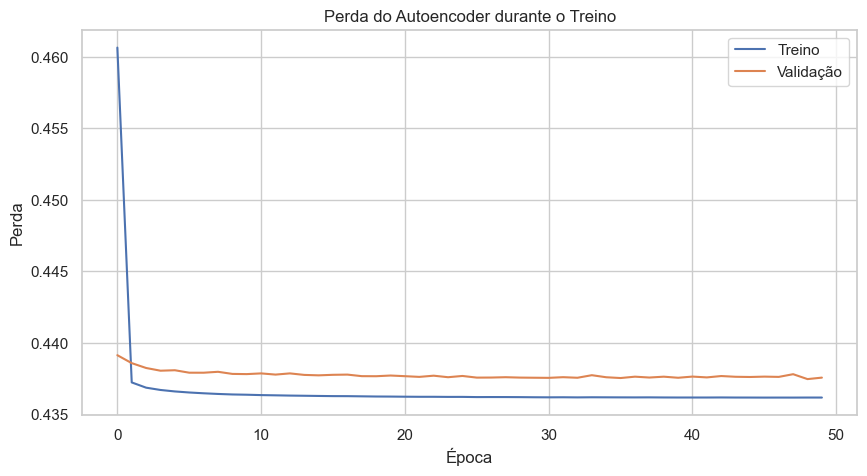

5577/5577 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step

Previsões do Autoencoder (0 = Normal, 1 = Anomalia):
[0 0 0 ... 0 0 0]


In [48]:
input_dim = X_train.shape[1]
encoding_dim = 8  

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(1e-5))(input_layer)
decoder = Dense(input_dim, activation='linear')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.15,
    verbose=1
)


plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Autoencoder durante o Treino')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()


X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)


threshold = np.percentile(mse, 95)
y_pred_ae = (mse > threshold).astype(int)

print("\nPrevisões do Autoencoder (0 = Normal, 1 = Anomalia):")
print(y_pred_ae)


### 11. Análise das Previsões de Anomalias
##### Criamos um DataFrame com as previsões e os erros de reconstrução para análise detalhada das anomalias detectadas.

In [49]:
df_predictions = pd.DataFrame({
    'Real': X_test[:, 0],  
    'Predito': mse,
    'Anomalia': y_pred_ae
})


print(df_predictions.head())


       Real   Predito  Anomalia
0  0.276422  0.084863         0
1 -0.781462  0.136071         0
2  0.934025  0.689922         0
3  0.322168  0.364444         0
4  0.516590  0.411972         0


### 12. Visualização das Previsões e Anomalias
##### Plotamos as previsões de erro de reconstrução e destacamos as anomalias detectadas.

C:\Users\rafae\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


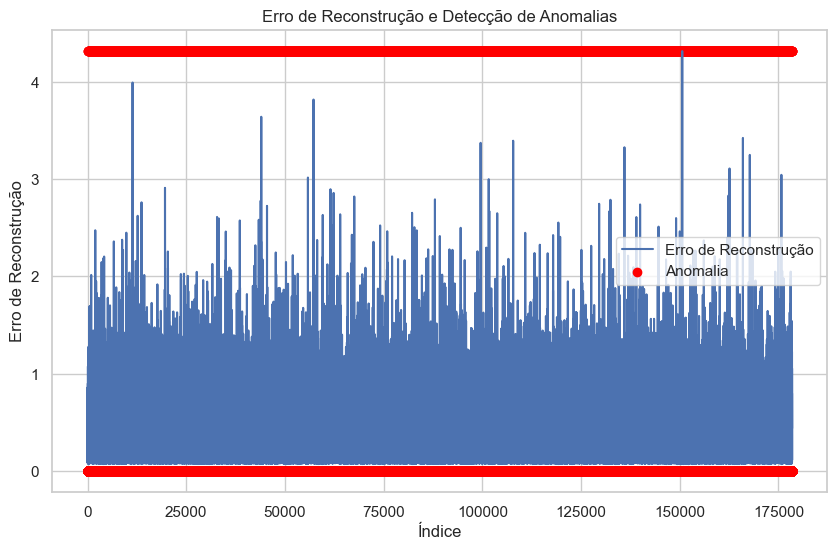

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(df_predictions['Predito'], label='Erro de Reconstrução')
plt.scatter(df_predictions.index, df_predictions['Anomalia'] * df_predictions['Predito'].max(), color='red', label='Anomalia')
plt.title('Erro de Reconstrução e Detecção de Anomalias')
plt.xlabel('Índice')
plt.ylabel('Erro de Reconstrução')
plt.legend()
plt.show()


In [ ]:
df_features = df_daily[features].copy()
from sklearn.model_selection import train_test_split
X_train, X_test, df_train, df_test = train_test_split(
    X_scaled, 
    df_features,
    test_size=0.2, 
    random_state=42
)


In [ ]:
df_test['mse'] = mse
df_test['anomaly_ae'] = y_pred_ae


anom_alias = df_test[df_test['anomaly_ae'] == 1]


print("\nAnomalias Detectadas pelo Autoencoder:")
print(anom_alias)


anom_alias.to_csv('anomalies_autoencoder.csv', index=False)



Anomalias Detectadas pelo Autoencoder:
        energy_consumption_kWh  peak_hour  holiday  occupied  day_of_week_num  \
396096                    2.51          1        1         0                6   
432582                    3.26          1        1         1                6   
614677                    8.79          0        0         1                4   
403154                    5.98          1        1         0                4   
823684                    4.49          0        1         1                3   
...                        ...        ...      ...       ...              ...   
218736                    3.84          1        1         0                0   
559400                    0.16          1        1         1                4   
740283                    7.48          2        0         1                5   
39008                     0.92          0        1         0                3   
340337                    1.03          1        1         1         

In [55]:
non_anomalias = df_test[df_test['anomaly_ae'] == 0]
non_anomalias.head(30)

,energy_consumption_kWh,peak_hour,holiday,occupied,day_of_week_num,season_Spring,season_Summer,season_Winter,appliance_Electronics,appliance_HVAC,...,appliance_Refrigerator,appliance_Washing Machine,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,mse,anomaly_ae
385869,3.34,0,0,1,0,True,False,False,False,False,...,False,False,True,False,False,False,False,False,0.084863,0
433354,1.49,0,0,0,6,False,True,False,True,False,...,False,False,False,False,True,False,False,False,0.136071,0
872159,4.49,0,0,0,3,False,False,True,False,False,...,True,False,False,False,False,True,False,False,0.689922,0
818994,3.42,0,0,1,5,True,False,False,False,False,...,False,True,False,True,False,False,False,False,0.364444,0
339736,3.76,0,0,0,2,False,True,False,False,False,...,True,False,False,False,False,False,False,True,0.411972,0
822490,2.62,1,0,1,1,False,False,False,False,False,...,False,False,False,False,False,False,True,False,0.326480,0
611400,0.61,0,0,0,0,True,False,False,False,False,...,False,True,True,False,False,False,False,False,0.457573,0
858194,2.97,1,0,1,3,False,True,False,False,False,...,True,False,False,False,False,True,False,False,0.839252,0
756557,4.65,0,0,1,4,True,False,False,False,False,...,True,False,False,False,False,False,False,False,0.428887,0
244022,4.12,0,0,1,3,False,False,False,False,False,...,True,False,False,False,False,True,False,False,0.707091,0


In [57]:
anom_alias.head(30)

,energy_consumption_kWh,peak_hour,holiday,occupied,day_of_week_num,season_Spring,season_Summer,season_Winter,appliance_Electronics,appliance_HVAC,...,appliance_Refrigerator,appliance_Washing Machine,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,mse,anomaly_ae
396096,2.51,1,1,0,6,False,False,False,False,True,...,False,False,False,False,True,False,False,False,1.075886,1
432582,3.26,1,1,1,6,False,False,False,False,False,...,False,True,False,False,True,False,False,False,1.104651,1
614677,8.79,0,0,1,4,False,True,False,False,False,...,False,True,False,False,False,False,False,False,1.015557,1
403154,5.98,1,1,0,4,False,False,False,False,False,...,True,False,False,False,False,False,False,False,1.277990,1
823684,4.49,0,1,1,3,True,False,False,False,False,...,False,False,False,False,False,True,False,False,0.971260,1
404454,7.10,0,0,1,3,False,False,True,False,False,...,False,True,False,False,False,True,False,False,0.981936,1
864543,1.55,0,1,1,6,False,False,False,False,False,...,False,True,False,False,True,False,False,False,0.918174,1
611950,2.61,0,1,0,3,False,False,True,False,True,...,False,False,False,False,False,True,False,False,1.114496,1
132195,8.71,0,0,0,6,False,False,False,False,False,...,True,False,False,False,True,False,False,False,0.982646,1
494798,7.52,0,1,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,1.206334,1


In [ ]:
media_energy_consumption = df_daily['energy_consumption_kWh'].mean()
print(f"Média de energy_consumption_kWh: {media_energy_consumption}")

Média de energy_consumption_kWh: 2.856600273686122
